# Validación de Features para ITG Stamina

Este cuaderno valida el pipeline de parseo y extracción de features para charts de stamina en ITG. Carga un archivo `.sm` de ejemplo, visualiza la densidad de notas por compás, deriva secuencias de stream/break y formatea texto de breakdown y métricas como evidencia para la tesis. Los gráficos usan Matplotlib (línea de notas por compás) y las funciones de `parser`/`features` se importan ajustando `sys.path` hacia `src`.

### Ruta del chart a mirar:

In [1]:
chart = "Stamina RPG 6/[23] Cycle Hit/Cycle Hit.sm"

In [2]:
%reload_ext autoreload

In [3]:
# Imports
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import PolyCollection
from pathlib import Path
import sys
from pprint import pprint
import matplotlib.pyplot as plt

In [4]:
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "notebooks" else NOTEBOOK_DIR
SRC_PATH = PROJECT_ROOT / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

print(f"Notebook directory: {NOTEBOOK_DIR}")
print(f"Project root: {PROJECT_ROOT}")
print(f"SRC path added: {SRC_PATH}")

Notebook directory: /home/maru/Documents/Tesina/ITGStamina-rater-ml/ml-core/notebooks
Project root: /home/maru/Documents/Tesina/ITGStamina-rater-ml/ml-core
SRC path added: /home/maru/Documents/Tesina/ITGStamina-rater-ml/ml-core/src


Loaded 231 measures from Cycle Hit.sm | subdivision: 24 | Display BPM: 175.0 | Meter (label): 23


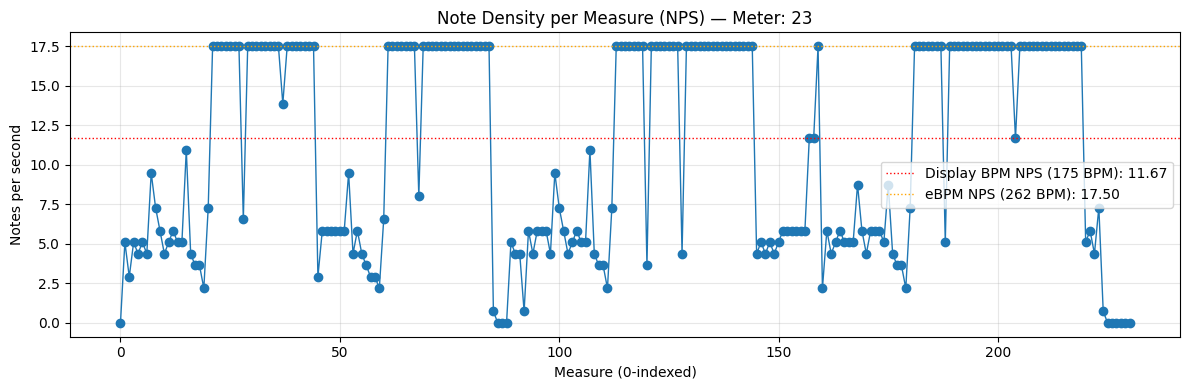

In [ ]:
from parser import parse_sm_chart_with_meta
from features import get_stream_sequences

chart_path = PROJECT_ROOT / "data/raw" / chart
notes_data, subdivision = parse_sm_chart_with_meta(chart_path)
densities = notes_data["notes_per_measure"]
display_bpm = notes_data["display_bpm"]
# ES: block es la variable objetivo (label) que el modelo debe predecir.
# EN: block is the target label the model must predict.
block = notes_data["block"]

# ES: Calcular NPS por compás y líneas de referencia.
# EN: Compute per-measure NPS and reference lines.
display_bpm_nps = None
ebpm_nps = None

if display_bpm and display_bpm > 0:
    measure_seconds = 240.0 / display_bpm
    nps_per_measure = [count / measure_seconds for count in densities]
    display_bpm_nps = display_bpm / 15.0

    # ES: eBPM = Display BPM × multiplicador de subdivisión detectada.
    # EN: eBPM = Display BPM × detected subdivision multiplier.
    sequences = get_stream_sequences(densities, subdivision=subdivision)
    if sequences:
        multiplier = sequences[0].get("multiplier", 1.0)
        ebpm = display_bpm * multiplier
        ebpm_nps = ebpm / 15.0
else:
    measure_seconds = None
    nps_per_measure = [np.nan for _ in densities]

print(
    f"Loaded {len(densities)} measures from {chart_path.name} | "
    f"subdivision: {subdivision} | Display BPM: {display_bpm} | Block (label): {block}"
)

plt.figure(figsize=(12, 4))
plt.plot(range(len(nps_per_measure)), nps_per_measure, marker="o", linewidth=1)
plt.title(f"Note Density per Measure (NPS) — Block: {block}")
plt.xlabel("Measure (0-indexed)")
plt.ylabel("Notes per second")
plt.grid(True, alpha=0.3)
if display_bpm_nps is not None:
    plt.axhline(
        display_bpm_nps,
        color="red",
        linestyle=":",
        linewidth=1,
        label=f"Display BPM NPS ({display_bpm:.0f} BPM): {display_bpm_nps:.2f}",
    )
if ebpm_nps is not None:
    plt.axhline(
        ebpm_nps,
        color="orange",
        linestyle=":",
        linewidth=1,
        label=f"eBPM NPS ({ebpm:.0f} BPM): {ebpm_nps:.2f}",
    )
if display_bpm_nps is not None or ebpm_nps is not None:
    plt.legend()
plt.tight_layout()
plt.show()


Como se observa, la densidad de notas revela las secciones de mayor carga y los breaks; esto se usa para derivar secuencias de stream/break y métricas de evidencia.

In [6]:
from features import (
    calculate_breakdown_metrics,
    generate_breakdown_string,
    get_stream_sequences,
)

sequences = get_stream_sequences(densities, subdivision=subdivision)
breakdown_text = generate_breakdown_string(densities, subdivision=subdivision)
metrics = calculate_breakdown_metrics(notes_data, subdivision=subdivision)

sequences_pretty = [
    {"length": seg["length"], "is_break": seg["is_break"], "start": seg["start"], "end": seg["end"]}
    for seg in sequences
]

print("Stream/Break Sequences:")
pprint(sequences_pretty, sort_dicts=False)
print("\nBreakdown String:")
print(breakdown_text)
print("\nMetrics:")
pprint(metrics)

Stream/Break Sequences:
[{'length': 7, 'is_break': False, 'start': 21, 'end': 27},
 {'length': 8, 'is_break': False, 'start': 29, 'end': 36},
 {'length': 7, 'is_break': False, 'start': 38, 'end': 44},
 {'length': 16, 'is_break': True, 'start': 45, 'end': 60},
 {'length': 7, 'is_break': False, 'start': 61, 'end': 67},
 {'length': 16, 'is_break': False, 'start': 69, 'end': 84},
 {'length': 28, 'is_break': True, 'start': 85, 'end': 112},
 {'length': 7, 'is_break': False, 'start': 113, 'end': 119},
 {'length': 7, 'is_break': False, 'start': 121, 'end': 127},
 {'length': 16, 'is_break': False, 'start': 129, 'end': 144},
 {'length': 14, 'is_break': True, 'start': 145, 'end': 158},
 {'length': 1, 'is_break': False, 'start': 159, 'end': 159},
 {'length': 21, 'is_break': True, 'start': 160, 'end': 180},
 {'length': 7, 'is_break': False, 'start': 181, 'end': 187},
 {'length': 15, 'is_break': False, 'start': 189, 'end': 203},
 {'length': 15, 'is_break': False, 'start': 205, 'end': 219}]

Breakdow

In [ ]:
print("--- ANALYSIS RESULT ---")
print(f"File: {chart_path.name}")
print(f"Subdivision detected: {subdivision}")
print(f"Display BPM: {display_bpm}")
# ES: El block es la variable objetivo (label) a predecir por el modelo de ML.
# EN: The block is the target variable (label) to be predicted by the ML model.
print(f"Block (label): {block}")
print(f"Calculated Breakdown: {breakdown_text}")

print("\nMetrics:")
print(f"- Total Stream: {metrics['total_stream_length']}")
print(f"- Max Stream: {metrics['max_stream_length']}")
print(f"- Break Count: {metrics['break_count']}")
print(f"- Stream/Break Ratio: {metrics['stream_break_ratio']:.3f}")
print(f"- Average NPS: {metrics['average_nps']:.3f}")
if metrics.get("ebpm") is None:
    print("- eBPM: None (BPM no disponible)")
else:
    print(f"- eBPM: {metrics['ebpm']:.1f}")


--- ANALYSIS RESULT ---
File: Cycle Hit.sm
Subdivision detected: 24
Display BPM: 175.0
Meter (label): 23
Calculated Breakdown: 10 12 10 (24) 10 24 (42) 10 10 24 (21) 1 (31) 10 22 22

Metrics:
- Total Stream: 165
- Max Stream: 24
- Break Count: 4
- Stream/Break Ratio: 1.398
- Average NPS: 11.108
- eBPM: 262.5
